In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
import copy
seed=1

In [2]:
X_train = pd.read_csv('./datamart/X_train_clipped_scaled.csv') #X_train_clipped_scaled
y_train = pd.read_csv('./datamart/y_protein_train.csv').values.ravel()
X_test = pd.read_csv('./datamart/X_test_clipped_scaled.csv') #X_test_clipped_scaled
y_test = pd.read_csv('./datamart/y_protein_test.csv').values.ravel()

In [3]:
mean = y_train.mean()
median = np.median(y_train)
print(root_mean_squared_error(y_test, [mean for i in range(len(y_test))]))
print(root_mean_squared_error(y_test, [median for i in range(len(y_test))]))
np.corrcoef(y_test, [mean for i in range(len(y_test))])

0.15027590306101302
0.15214485590263713


array([[1.00000000e+00, 1.80971413e-15],
       [1.80971413e-15, 1.00000000e+00]])

In [4]:
def grid_search(estimator, param_grid, cv, fit_params=None, X_train=None, y_train=None):

    # Define the grid search with RMSE scoring
    grid_search = GridSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', cv=cv)
    
    # Fit the grid search
    if fit_params is not None:
        grid_search.fit(X_train, y_train, **fit_params)
    else:
        grid_search.fit(X_train, y_train)
    
    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_params = {key.split('__', 1)[1] if '__' in key else key: value for key, value in best_params.items()}
    best_score = grid_search.best_score_
    
    # Convert negative MSE to RMSE
    best_rmse = best_score * -1
    
    print("Best Parameters: ", best_params)
    print("Best RMSE: ", best_rmse)
    
    return best_params, best_rmse


In [5]:
def evaluate_estimator(estimator, X_train, y_train, X_test, y_test):

    # Predict on training and validation data
    train_pred = estimator.predict(X_train)
    val_pred = estimator.predict(X_test)
    
    # Calculate RMSE for training and validation sets
    train_rmse = root_mean_squared_error(y_train, train_pred)
    val_rmse = root_mean_squared_error(y_test, val_pred)
    
    print('Train RMSE:', train_rmse)
    print('Test RMSE:', val_rmse)
    print('Corr', np.corrcoef(y_test, val_pred)[0,1])
    return train_rmse, val_rmse


In [6]:
kfold = RepeatedKFold(n_splits=5, random_state=seed, n_repeats=2)

In [7]:
dt = DecisionTreeRegressor(random_state=seed)

# Define the parameter grid for decision tree regressor
param_grid = {
    'max_depth': [1,2,3],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [1,2,3]
}
dt_best_params, dt_best_score = grid_search(dt, param_grid, cv=kfold, X_train=X_train, y_train=y_train)


Best Parameters:  {'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best RMSE:  0.15742283115765657


In [8]:
dt =  DecisionTreeRegressor(**dt_best_params, random_state=seed)
dt.fit(X_train, y_train)
dt_train_error, dt_test_error= evaluate_estimator(dt, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Train RMSE: 0.1429185614246393
Test RMSE: 0.1546113013630925
Corr -0.08363134843582593


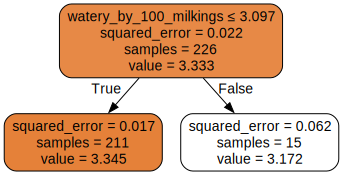

In [9]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(dt,
                                out_file=None,
                                feature_names=X_train.columns,
                                filled=True,
                                rounded=True,
                                special_characters=True)

# Create a Graphviz source object
graph = graphviz.Source(dot_data)
graph

In [10]:
rf = RandomForestRegressor(random_state=seed)

# Define the parameter grid for Random Forest Regressor
param_grid = {
    'n_estimators': [80,90,100],
    'max_depth': [2, 3, 4]
}
rf_best_params, rf_best_score = grid_search(rf, param_grid, cv=kfold, X_train=X_train, y_train=y_train)

In [ ]:
rf = RandomForestRegressor(**rf_best_params,random_state=seed)
rf.fit(X_train, y_train)
rf_train_error, rf_test_error= evaluate_estimator(rf, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Train RMSE: 0.10420689621301926
Test RMSE: 0.14310367267056798


In [ ]:
gb = GradientBoostingRegressor(random_state=seed)

# Define the parameter grid for Gradient Boosting Regressor
param_grid = {
    'n_estimators': [10, 25, 50, 75],
    'learning_rate': [0.01, 0.05],
    'max_depth': [1,2]
}
gb_best_params, gb_best_score = grid_search(gb, param_grid, cv=kfold, X_train=X_train, y_train=y_train)


Best Parameters:  {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50}
Best RMSE:  0.1456949668879271


In [ ]:
gb = GradientBoostingRegressor(**gb_best_params,random_state=seed)
gb.fit(X_train, y_train)
gb_train_error, gb_test_error= evaluate_estimator(gb, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Train RMSE: 0.11397452713132661
Test RMSE: 0.1445641894657515


In [ ]:
svr = SVR()

param_grid = {
    'C': [0.001,0.01, 0.1],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['linear', 'rbf']
}
svr_best_params, svr_best_score = grid_search(svr, param_grid, cv=kfold, X_train=X_train, y_train=y_train)


Best Parameters:  {'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}
Best RMSE:  0.14054827681629


In [ ]:
svr = SVR(**svr_best_params)
svr.fit(X_train, y_train)
svr_train_error, svr_test_error= evaluate_estimator(svr, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Train RMSE: 0.13450316201035012
Test RMSE: 0.140510465007968


In [ ]:
lr =  LinearRegression()
param_grid = {}
lr_best_params, lr_best_score = grid_search(lr, param_grid, cv=kfold, X_train=X_train, y_train=y_train)


Best Parameters:  {}
Best RMSE:  0.14169829011505466


In [ ]:
lr = LinearRegression(**lr_best_params)
svr.fit(X_train, y_train)
svr_train_error, svr_test_error= evaluate_estimator(svr, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Train RMSE: 0.13450316201035012
Test RMSE: 0.140510465007968


In [ ]:
en = ElasticNet()
param_grid = {
    'alpha': [0.001, 0.01, 0.1],
    'l1_ratio': [0.3, 0.4,0.5,0.6,0.7]
}
en_best_params, en_best_score = grid_search(en, param_grid, cv=kfold, X_train=X_train, y_train=y_train)

Best Parameters:  {'alpha': 0.01, 'l1_ratio': 0.6}
Best RMSE:  0.13951111251273013


In [ ]:
en = ElasticNet(**en_best_params)
en.fit(X_train, y_train)
en_train_error, en_test_error= evaluate_estimator(en, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Train RMSE: 0.13407396884049835
Test RMSE: 0.13871016226990393
